# Evaluate models on Antarctica data

## Load data and model

In [6]:
import pandas as pd
from joblib import load
import numpy as np

def get_modis_classifications(data):
    modis_classifications = np.where(data.mWater.values, 1, 0) +\
            np.where(data.mIce.values, 2, 0) +\
            np.where(data.mUndetermined.values, 3, 0)
    return pd.Series(modis_classifications, index=data.index)

anarctica_folder = './JASMIN_tests/Antarctica/merged_features/'

model_type = "infrared"

if model_type == 'infrared':
    features = [
        'band_25', 'band_27', 'band_36', 'BTD85_11', 'BTD73_11', 'BT73',
       'BTD12_11', 'BTD39_11', 'mLST_night', 'mSZA'
    ]

    data = pd.read_csv(anarctica_folder + "clean_infrared_features.csv")
    data = data[data.mLat < -60]
    modis_classifications = get_modis_classifications(data)
    data = data[features]
    labels = pd.read_csv(anarctica_folder + "clean_infrared_labels.csv")['class']
    RF = load('./2013_2017_DATA/trained_models/RF infrared (night-only)_run_57.joblib')
elif model_type == 'optical':
    features = [
        'band_7', 'band_18', 'band_20', 'band_25', 'band_26', 'band_27',
       'band_28', 'band_29', 'mSZA', 'mCloudTopPressure'
    ]
    
    data = pd.read_csv(anarctica_folder + "clean_optical_features.csv")
    data = data[data.mLat < -60]
    modis_classifications = get_modis_classifications(data)
    data = data[features]
    labels = pd.read_csv(anarctica_folder + "clean_optical_labels.csv")['class']
    RF = load('./2013_2017_DATA/trained_models/RF optical (day-only)_run_57.joblib')

print(f"{model_type} data", data.shape)
display(data.head())

print(f"{model_type} labels", labels.shape)
display(labels.head())

print(RF)

infrared data (8074861, 10)


,band_25,band_27,band_36,BTD85_11,BTD73_11,BT73,BTD12_11,BTD39_11,mLST_night,mSZA
0,0.1214,1.0504,2.7859,0.965324,-6.144915,243.871436,-2.154739,8.206365,260.08,84.12
1,0.1226,1.0590,2.7970,0.353406,-6.414974,244.325338,-1.587471,9.360495,262.92,83.69
2,0.1183,1.0442,2.8210,-0.109341,-4.936209,243.828671,-0.259184,9.633748,258.94,83.65
3,0.1241,1.0712,2.7831,-0.209316,-5.970964,244.318576,-0.881033,9.190903,261.90,83.61
4,0.1181,1.0666,2.7955,-0.203965,-5.085836,244.130467,-0.401582,8.104397,257.88,83.57


infrared labels (9217922,)


0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

RandomForestClassifier(ccp_alpha=0, max_depth=40, min_samples_leaf=2,
                       n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=26, verbose=1)


## Debug nans

In [7]:
data.isna().sum()

# remove the rows with nan values, there are very few of them
data = data.dropna()

# correct for the labels
labels = labels.loc[data.index]

# correct for the modis classifications
modis_classifications = modis_classifications[data.index]

## Print CALIOP classification statistics

In [8]:
# print the number of datapoints with each class and the percentage from the total
total_datapoints = len(labels)
print("Clear profiles", len(labels[labels == 0]), len(labels[labels == 0]) / total_datapoints)
print("Water profiles", len(labels[labels == 1]), len(labels[labels == 1]) / total_datapoints)
print("Ice profiles", len(labels[labels == 2]), len(labels[labels == 2]) / total_datapoints)



Clear profiles 2723023 0.3374675548073415
Water profiles 663978 0.08228760172274306
Ice profiles 4681991 0.5802448434699155


## Predict

In [9]:
predicted_phases = RF.predict(data)

/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtyp

## Plot

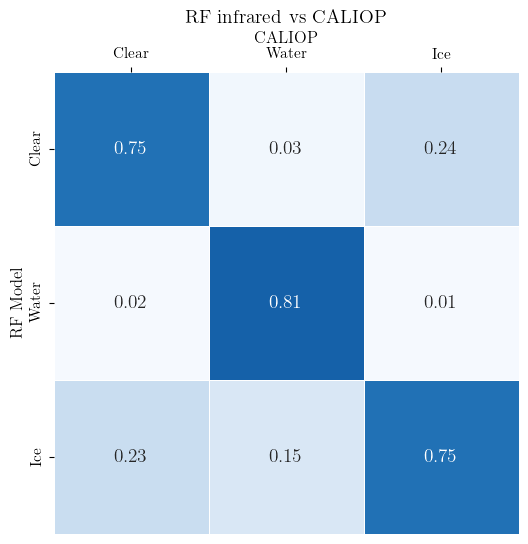

Accuracy: 77.01%
Accuracy: 51.88%


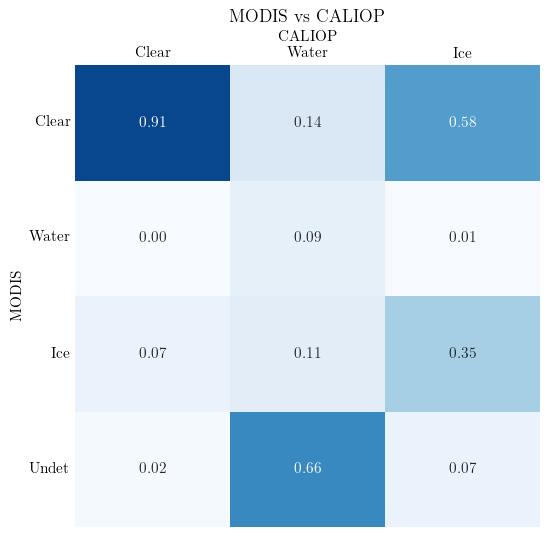

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def test_train_split_day_batches(data, test_size=0.2, random_seed=26):
    cycle_day = 20
    testing_days = int(test_size * cycle_day)

    if testing_days == 0:
        testing_days = 1

    datetimes = pd.to_datetime(data["cFileID"].apply(lambda x: x[0:10]), format="%Y-%m-%d")

    # get the earliest date in the dataset
    earliest_date = datetimes.min()
    days_since_earliest_date = (datetimes - earliest_date).dt.days

    # get the unique days list and shuffle them
    unique_days = days_since_earliest_date.unique()
    # np.random.seed(random_seed)
    # np.random.shuffle(unique_days)

    test_data = data[days_since_earliest_date.isin(unique_days[0::cycle_day])]
    for testing_day in range(1, testing_days):
        test_data = pd.concat([test_data, data[days_since_earliest_date.isin(unique_days[testing_day::cycle_day])]], axis=0)

    train_data = data[~data.index.isin(test_data.index)]

    return train_data, test_data

def easy_confusion(model_labels, caliop_labels, title="Model vs CALIOP", save=False, save_path=None):
    confusion_table = pd.crosstab(caliop_labels, model_labels, rownames=["Caliop"], colnames=["Model"], normalize="index")

    # get accuracy score
    accuracy = np.trace(confusion_table) / np.sum(confusion_table.values)

    confusion_table.columns = ["Clear", "Water", "Ice"]
    confusion_table.index = ["Clear", "Water", "Ice"]

    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.serif'] = 'Computer Modern Roman'
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot correlation matrix
    sns.heatmap(confusion_table.T, cmap="Blues", annot=True, fmt=".2f", linewidths=.5, ax=ax, cbar=False, vmin=0, vmax=1, annot_kws={"size": 14})

    # Set plot labels
    ax.set_title("Confusion Matrix")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90)
    ax.xaxis.tick_top()  # Place x-axis labels on top
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("CALIOP", fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel("RF Model", fontsize=12)

    # Show the plot
    plt.show()

    if save:
        fig.savefig(save_path, bbox_inches="tight", dpi=300)
    
    return confusion_table, accuracy*100

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern'

def plot_confusion_matrix_modis_caliop(caliop_labels, modis_labels, title="MODIS vs CALIOP", plot_ylabel=True, save=False, save_path=None):
    confusion_table = pd.crosstab(caliop_labels, modis_labels, rownames=["Caliop"], colnames=["Model"])

    # get accuracy score
    accuracy = np.trace(confusion_table) / np.sum(confusion_table.values)

    confusion_table = pd.crosstab(caliop_labels, modis_labels, rownames=["Caliop"], colnames=["Model"], normalize="index")
    if plot_ylabel:
        confusion_table.columns = ["Clear", "Water", "Ice", "Undet"]
    else:
        confusion_table.columns = ["", "", "", ""]
    confusion_table.index = ["Clear", "Water", "Ice"]

    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot correlation matrix
    h = sns.heatmap(confusion_table.T, cmap="Blues", annot=True, fmt=".2f", ax=ax, cbar=False, vmin=0, vmax=1, annot_kws={"fontsize":11})

    # Set plot labels
    ax.set_title("Confusion Matrix")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.xaxis.tick_top()  # Place x-axis labels on top
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("CALIOP")
    ax.xaxis.set_label_position('top')
    ax.set_ylabel("MODIS")

    # remove x and y label ticks, but not the labels themselves
    ax.tick_params(axis=u'both', which=u'both',length=0)

    if not plot_ylabel:
        ax.set_ylabel("")

    if save:
        h.figure.savefig(save_path, bbox_inches="tight", dpi=300)
    
    return confusion_table, accuracy*100


confusion_table, accuracy = easy_confusion(predicted_phases, labels, title=f"RF {model_type} vs CALIOP", save=True, save_path=f"./JASMIN_tests/Antarctica/RF_{model_type}_confusion.png")
print(f"Accuracy: {accuracy:.4g}%")

confusion_table, accuracy = plot_confusion_matrix_modis_caliop(labels, modis_classifications, title=f"MODIS vs CALIOP", save=False, save_path=f"./JASMIN_tests/Antarctica/MODIS_confusion.png")
print(f"Accuracy: {accuracy:.4g}%")
